<a href="https://colab.research.google.com/github/Flychuban/Fat_Percentage_Prediction/blob/main/Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.2 MB/s eta 0:00:00


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor

In [35]:
df = pd.read_csv('/content/drive/MyDrive/BodyFatPrediction/bodyfat.csv')
df.head(10)

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
5,1.0502,20.9,24,210.25,74.75,39.0,104.5,94.4,107.8,66.0,42.0,25.6,35.7,30.6,18.8
6,1.0549,19.2,26,181.00,69.75,36.4,105.1,90.7,100.3,58.4,38.3,22.9,31.9,27.8,17.7
7,1.0704,12.4,25,176.00,72.50,37.8,99.6,88.5,97.1,60.0,39.4,23.2,30.5,29.0,18.8
8,1.0900,4.1,25,191.00,74.00,38.1,100.9,82.5,99.9,62.9,38.3,23.8,35.9,31.1,18.2
9,1.0722,11.7,23,198.25,73.50,42.1,99.6,88.6,104.1,63.1,41.7,25.0,35.6,30.0,19.2


Transform lbb to kg
          inch to cm
Drop Density because of the high negative correlation with Body Fat.
Run just once for right corrections

In [36]:
df['Weight'] = [x * 0.453 for x in df['Weight']]
df['Height'] = [x * 2.54 for x in df['Height']]
df.drop(columns=['Density'], axis=0, inplace=True)

In [37]:
df.head(10)

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,12.3,23,69.87525,172.085,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,22,78.48225,183.515,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,22,69.76200,168.275,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,26,83.69175,183.515,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,24,83.46525,180.975,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
5,20.9,24,95.24325,189.865,39.0,104.5,94.4,107.8,66.0,42.0,25.6,35.7,30.6,18.8
6,19.2,26,81.99300,177.165,36.4,105.1,90.7,100.3,58.4,38.3,22.9,31.9,27.8,17.7
7,12.4,25,79.72800,184.150,37.8,99.6,88.5,97.1,60.0,39.4,23.2,30.5,29.0,18.8
8,4.1,25,86.52300,187.960,38.1,100.9,82.5,99.9,62.9,38.3,23.8,35.9,31.1,18.2
9,11.7,23,89.80725,186.690,42.1,99.6,88.6,104.1,63.1,41.7,25.0,35.6,30.0,19.2


Data analysis

In [38]:
# All valuse are not NULL
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BodyFat  252 non-null    float64
 1   Age      252 non-null    int64  
 2   Weight   252 non-null    float64
 3   Height   252 non-null    float64
 4   Neck     252 non-null    float64
 5   Chest    252 non-null    float64
 6   Abdomen  252 non-null    float64
 7   Hip      252 non-null    float64
 8   Thigh    252 non-null    float64
 9   Knee     252 non-null    float64
 10  Ankle    252 non-null    float64
 11  Biceps   252 non-null    float64
 12  Forearm  252 non-null    float64
 13  Wrist    252 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 27.7 KB


In [39]:
df.describe()

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,19.150794,44.884921,81.052755,178.177976,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762
std,8.368740,12.602040,13.313289,9.303654,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585
min,0.000000,22.000000,53.680500,74.930000,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000
25%,12.475000,35.750000,72.027000,173.355000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,19.200000,43.000000,79.954500,177.800000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000
75%,25.300000,54.000000,89.241000,183.515000,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,47.500000,81.000000,164.506950,197.485000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


<Axes: >

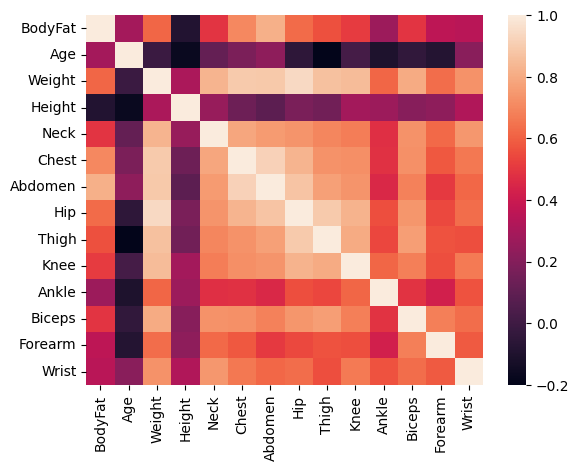

In [40]:
# We can see that there aren't very strong correlations which is good
corr = df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [41]:
df

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,12.3,23,69.87525,172.085,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,22,78.48225,183.515,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,22,69.76200,168.275,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,26,83.69175,183.515,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,24,83.46525,180.975,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,11.0,70,60.81525,170.180,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5
248,33.6,72,91.05300,177.165,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1
249,29.3,72,84.59775,167.640,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0
250,26.0,72,86.40975,179.070,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8


Get all features and labels

In [42]:
y = df['BodyFat']
X = df.drop(columns=['BodyFat'], axis=0, inplace=False)

Data should be scaled (MinMax or Standard )

In [43]:
scaler = MinMaxScaler()
scaler.fit(X, y)

column_names = X.columns
X[column_names] = scaler.transform(X)

In [44]:
X.head()

,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,0.016949,0.146127,0.792746,0.253731,0.242531,0.200762,0.151515,0.294264,0.267081,0.189189,0.356436,0.460432,0.232143
1,0.000000,0.223789,0.886010,0.368159,0.251318,0.172808,0.218501,0.286783,0.267081,0.290541,0.282178,0.568345,0.428571
2,0.000000,0.145105,0.761658,0.144279,0.289982,0.235070,0.226475,0.309227,0.366460,0.331081,0.198020,0.302158,0.142857
3,0.067797,0.270795,0.886010,0.313433,0.395431,0.216010,0.258373,0.321696,0.267081,0.250000,0.376238,0.604317,0.428571
4,0.033898,0.268751,0.865285,0.164179,0.316344,0.388818,0.269537,0.399002,0.571429,0.331081,0.366337,0.482014,0.339286


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, shuffle=True)

Let's see model performance using Random Forest

In [53]:
def random_forest():
  # Prepearing info for Grid Search best params
  n_estimators = [int(x) for x in np.linspace(start=10, stop=80, num=10)]
  max_features = ['auto', 'sqrt']
  max_depth = [2, 4]
  min_samples_split = [2, 5]
  min_samples_leaf = [1, 2]
  bootstrap = [True, False]

  param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
  }

  rf_Model = RandomForestRegressor()

  # Finding best params for RandomForest
  rf_Grid = GridSearchCV(estimator=rf_Model, param_grid = param_grid, cv = 3, verbose=2, n_jobs=4)

  rf_Grid.fit(X_train, y_train)

  score_train = rf_Grid.score(X_train, y_train)
  score_test = rf_Grid.score(X_test, y_test)
  print(f"Random Forest  Train Score:  {score_train}")
  print(f"Random Forest  Test Score:  {score_test}")

  return rf_Grid

In [52]:
def sklearn_models_build(model):
  model.fit(X_train, y_train)

  score_train = model.score(X_train, y_train)
  score_test = model.score(X_test, y_test)
  print(f"Train Score:  {score_train}")
  print(f"Test Score:  {score_test}")
  return model

In [63]:
random_forest()

print("Linear Regression")
sklearn_models_build(LinearRegression())

print("LGBMRegressor")
sklearn_models_build(LGBMRegressor())

print("XGBRegressor")
sklearn_models_build(XGBRegressor())

print("CatBoostRegressor")
sklearn_models_build(CatBoostRegressor())

print("SGDRegressor")
sklearn_models_build(SGDRegressor())

print("KernelRidge")
sklearn_models_build(KernelRidge())

print("ElasticNet")
sklearn_models_build(ElasticNet())

print("BayesianRidge")
sklearn_models_build(BayesianRidge())

print("GradientBoostingRegressor")
sklearn_models_build(GradientBoostingRegressor())

Fitting 3 folds for each of 320 candidates, totalling 960 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Random Forest  Train Score:  0.8348318773930414
Random Forest  Test Score:  0.7396284420062322
Linear Regression
Train Score:  0.7354234718482391
Test Score:  0.7873839125262532
LGBMRegressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 201, number of used features: 13
[LightGBM] [Info] Start training from score 19.055224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Train Score:  0.9765782721385972
Test Score:  0.7264686764756776


GradientBoostingRegressor()

We can see that LinearRegression and BayesianRidge have best performance. I will choose to use LinearRegression because it's easier to implement